# Comparative analysis of structural, learned, and hybrid feature representations for graph clustering

##### Final "Learning From Networks" course project
##### Authors: Chiara Frizzarin, Leonardo Gusson, Luca Rao
##### Date: 16/01/2026

---
## Notebook configuration

Use the following configuration cell to control the notebook's execution behavior.

By default, the `RECOMPUTE_*` flags are set to `False` to load pre-calculated results included in the repository at
`../data/processed/`.
The `DEVICE` parameter determines whether computations run on the CPU or GPU for functions that support acceleration.

In [1]:
import sys, os
from pathlib import Path

DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

INPUT_DATA_PATH = DATA_DIR / "amazon-meta.txt"
PICKLE_PATH = PROCESSED_DATA_DIR / "amazon_graph.pickle"
HARMSCORE_PATH = PROCESSED_DATA_DIR / "harmonic_scores.csv"
BETSCORE_PATH = PROCESSED_DATA_DIR / "bet_scores.csv"
CLUSSCORE_PATH = PROCESSED_DATA_DIR / "clus_scores.csv"
PRSCORE_PATH = PROCESSED_DATA_DIR / "pagerank_scores.csv"
EMBEDDINGS_PATH = PROCESSED_DATA_DIR / "embeddings_p1_q2.csv"

class Config:
    DEVICE = "cuda"     # options: "cpu", "cuda"
    USE_HANDMADE_IMPLEMENTATIONS = True

    RECOMPUTE_DATA_PROCESSING = False
    RECOMPUTE_HARMONIC_CENTRALITY = False       # has 'cpu' and 'cuda' versions, both hand-made implementations
    RECOMPUTE_BETWEENNESS_CENTRALITY = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_CLUSTERING_COEFFICIENT = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_PAGERANK = False                  # has 'cpu' and 'cuda' versions, both hand-made implementations

    RECOMPUTE_EMBEDDINGS = False                # has 'cpu' and 'cuda' versions, both hand-made implementations

config = Config()

---
## Common imports

In [2]:
import sys
import time
import numpy as np
import pandas as pd
import hashlib
import re
import gc

import pickle
import networkx as nx

# other dependencies...

if  config.RECOMPUTE_HARMONIC_CENTRALITY and config.DEVICE == 'cuda':
    import cupy as cp

if  config.RECOMPUTE_EMBEDDINGS and config.DEVICE == 'cpu':
    from node2vec import Node2Vec

if  config.RECOMPUTE_EMBEDDINGS and config.DEVICE == 'cuda':
    import torch
    from torch_geometric.nn import Node2Vec as torch_Node2Vec
    from torch_geometric.utils import from_networkx

sys.path.append(os.path.abspath('..'))

---
## Data processing

In [3]:
from src import parse_amazon_graph_data

if config.RECOMPUTE_DATA_PROCESSING:
    start_time = time.time()
    parse_amazon_graph_data(INPUT_DATA_PATH, PICKLE_PATH)
    elapsed = time.time() - start_time
    print(f"Data processing completed in {elapsed:.2f} seconds.")

# Load the input graph from the pickle file
with open(PICKLE_PATH, "rb") as f:
    G = pickle.load(f)

print("Graph loaded")

Configurazione completata. Output sarà:  ../data/processed/amazon_graph.pickle
Graph loaded


---
## Structural features

### Harmonic centrality
...

In [4]:
from src import load_or_compute
from src.features import get_harmonic_centrality


start_time = time.time()

df_harmonic_scores = load_or_compute(
    HARMSCORE_PATH,
    get_harmonic_centrality,
    config.RECOMPUTE_HARMONIC_CENTRALITY,
    G=G,
    p=10,
    version=config.DEVICE
)
display(df_harmonic_scores.head(5))

elapsed = time.time() - start_time
print(
    f"Harmonic centrality "
    f"{'recomputed' if config.RECOMPUTE_HARMONIC_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,ASIN,HarmonicCentrality
0,0827229534,10890.978000
1,0738700797,9056.977000
2,0842328327,2.840921
3,1577943082,5.111011
4,0486220125,0.000000


Harmonic centrality loaded in 0.34 seconds.


### Betweenness Centrality
...

In [5]:
from src import load_or_compute
from src.features import get_approx_betweenness


start_time = time.time()

df_bet = load_or_compute(
    BETSCORE_PATH,
    get_approx_betweenness,
    config.RECOMPUTE_BETWEENNESS_CENTRALITY,
    G=G,
    k=1000
)
display(df_bet.head(5))

elapsed = time.time() - start_time
print(
    f"Betweenness centrality "
    f"{'recomputed' if config.RECOMPUTE_BETWEENNESS_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,Betweenness
ASIN,
0827229534,0.0
0738700797,0.0
0842328327,0.0
1577943082,0.0
0486220125,0.0


Betweenness centrality loaded in 0.37 seconds.


### PageRank
...

In [6]:
from src import load_or_compute
from src.features import get_pagerank


start_time = time.time()

df_pagerank = load_or_compute(
    PRSCORE_PATH,
    get_pagerank,
    config.RECOMPUTE_PAGERANK,
    G=G,
    force_cpu=(config.DEVICE == 'cpu')
)
display(df_pagerank.head(5))

elapsed = time.time() - start_time
print(
    f"Page Rank "
    f"{'recomputed' if config.RECOMPUTE_PAGERANK else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,pagerank
ASIN,
0827229534,5.332977e-06
0738700797,9.438284e-06
0842328327,6.925232e-07
1577943082,1.400741e-06
0486220125,4.671820e-07


Page Rank loaded in 0.62 seconds.


### Clustering Coefficient
...

In [7]:
from src import load_or_compute
from src.features import get_clustering_coefficient

start_time = time.time()

df_clus = load_or_compute(
    CLUSSCORE_PATH,
    get_clustering_coefficient,
    config.RECOMPUTE_CLUSTERING_COEFFICIENT,
    G=G
)
display(df_clus.head(5))

elapsed = time.time() - start_time
print(
    f"Clustering coefficient "
    f"{'recomputed' if config.RECOMPUTE_CLUSTERING_COEFFICIENT else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,ClusteringCoefficient
ASIN,
0827229534,0.136364
0738700797,0.241758
0842328327,0.333333
1577943082,0.450000
0486220125,0.250000


Clustering coefficient loaded in 0.41 seconds.


### Structural features vector

In [8]:
struct_df = [df_pagerank,df_clus,df_bet,df_harmonic_scores]
df_final = pd.concat(struct_df,axis=1)

### SalesRank score
...

In [9]:

salesrank_dict = nx.get_node_attributes(G, 'salesrank')

# Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

# Join to df_final
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank
0827229534,5.332977e-06,0.136364,0.0,NaN,NaN,396585.0
0738700797,9.438284e-06,0.241758,0.0,NaN,NaN,168596.0
0842328327,6.925232e-07,0.333333,0.0,NaN,NaN,631289.0
1577943082,1.400741e-06,0.450000,0.0,NaN,NaN,455160.0
0486220125,4.671820e-07,0.250000,0.0,NaN,NaN,188784.0


### Review Scores
In this case we need to use the merge intead of join because the score reviews are computed on the whole dataset instead of the LCC and so we need to ensure that only scores with the same ASIN are added

In [10]:
df_review = pd.read_csv("../data/processed/review_scores.csv")
df_review.set_index("ASIN", inplace=True)
df_review.head()

,rw_score,num_reviews
ASIN,,
0827229534,5.000000,2
0738700797,4.136364,12
0486287785,5.000000,1
0842328327,4.000000,1
0486220125,4.550296,17


In [11]:
df_final = pd.merge(df_final, 
    df_review[['rw_score']], 
    on='ASIN', how='left')

In [12]:
#TODO sometimes in rw_Score Nan are present 
df_final = df_final.fillna(0)
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank,rw_score
0,5.332977e-06,0.136364,0.0,0,0.0,396585.0,0.0
1,9.438284e-06,0.241758,0.0,0,0.0,168596.0,0.0
2,6.925232e-07,0.333333,0.0,0,0.0,631289.0,0.0
3,1.400741e-06,0.450000,0.0,0,0.0,455160.0,0.0
4,4.671820e-07,0.250000,0.0,0,0.0,188784.0,0.0


In [13]:
df_final.to_csv("../data/processed/structural_metrics.csv")

---
## Clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_final['salesrank_log'] = np.log1p(df_final['salesrank'])
features = ['pagerank','Betweenness','ClusteringCoefficient','HarmonicCentrality','salesrank_log','rw_score']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

In [15]:
X.head()

,pagerank,Betweenness,ClusteringCoefficient,HarmonicCentrality,salesrank_log,rw_score
0,5.332977e-06,0.0,0.136364,0.0,12.890648,0.0
1,9.438284e-06,0.0,0.241758,0.0,12.035267,0.0
2,6.925232e-07,0.0,0.333333,0.0,13.355521,0.0
3,1.400741e-06,0.0,0.450000,0.0,13.028406,0.0
4,4.671820e-07,0.0,0.250000,0.0,12.148364,0.0


Standardize

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features) # to check mean and variance of std data

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)

df_final['cluster_kmeans'] = clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
1    334077
3    199029
2     92171
0     44409
Name: count, dtype: int64


In [17]:
print("Mean of scaled structural features:")
print(df_scaled.mean())
print("Std of scaled structural features:")
print(df_scaled.std())

Mean of scaled structural features:
pagerank                 8.691784e-17
Betweenness             -2.172946e-17
ClusteringCoefficient    4.345892e-17
HarmonicCentrality       0.000000e+00
salesrank_log            0.000000e+00
rw_score                 8.691784e-17
dtype: float64
Std of scaled structural features:
pagerank                 1.000001
Betweenness              1.000001
ClusteringCoefficient    1.000001
HarmonicCentrality       1.000001
salesrank_log            1.000001
rw_score                 1.000001
dtype: float64


confronto con gruppi 

In [ ]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# 3. Unisci al tuo df_final
# Remove 'group' from node attributes if it exists to avoid conflict
if 'group' in df_final.columns:
    df_final = df_final.drop(columns=['group'])

# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

,group
0827229534,Book
0738700797,Book
0842328327,Book
1577943082,Book
0486220125,Book
B00000AU3R,Music
0231118597,Book
0375709363,Book
0871318237,Book
1590770218,Book


,group
ASIN,
0827229534,Book
0738700797,Book
0842328327,Book
1577943082,Book
0486220125,Book
B00000AU3R,Music
0231118597,Book
0375709363,Book
0871318237,Book


In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

Empty DataFrame
Columns: []
Index: []


,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_kmeans,group
0,5.332977e-06,0.136364,0.0,0,0.0,396585.0,0.0,12.890648,1,NaN
1,9.438284e-06,0.241758,0.0,0,0.0,168596.0,0.0,12.035267,1,NaN
2,6.925232e-07,0.333333,0.0,0,0.0,631289.0,0.0,13.355521,1,NaN
3,1.400741e-06,0.450000,0.0,0,0.0,455160.0,0.0,13.028406,1,NaN
4,4.671820e-07,0.250000,0.0,0,0.0,188784.0,0.0,12.148364,1,NaN


In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x600 with 0 Axes>

---
## Embeddings

In [ ]:
from src import load_or_compute
from src.features import get_node2vec_embeddings

start_time = time.time()

df_embeddings = load_or_compute(
    EMBEDDINGS_PATH,
    get_node2vec_embeddings,
    config.RECOMPUTE_EMBEDDINGS,
    G=G,
    version=config.DEVICE,
)
display(df_embeddings.head(5))

elapsed = time.time() - start_time
print(
    f"Embeddings "
    f"{'recomputed' if config.RECOMPUTE_EMBEDDINGS else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,-0.039401,0.319984,0.147284,-0.009532,0.272835,-0.001497,0.153352,-0.207378,-0.183975,-0.311063,...,0.081881,-0.115338,-0.032910,-0.150788,0.118194,-0.140970,0.233102,0.003224,-0.074887,0.041781
0738700797,-0.084367,-0.033158,0.071312,0.463542,0.294667,0.372568,-0.331131,0.021473,-0.076870,0.174803,...,-0.639531,-0.200339,-0.190223,0.060360,-0.026398,-0.017045,-0.027020,0.032294,0.485112,-0.385177
0842328327,-0.200147,-0.074771,-0.087528,-0.043276,0.022293,-0.093859,0.133483,-0.069090,-0.360008,-0.099777,...,0.233975,0.130195,-0.013525,0.121875,-0.025883,-0.060119,-0.010186,-0.201285,0.039958,0.162182
1577943082,0.014877,-0.008863,-0.170374,-0.356302,0.073383,-0.284318,0.000955,0.341354,0.066642,0.012515,...,0.273996,-0.070449,0.021338,-0.042039,0.395966,0.000411,0.084225,0.013561,-0.279434,0.081551
0486220125,-0.083501,-0.019884,-0.118082,0.031206,0.080626,-0.005765,-0.009929,-0.201525,-0.061848,0.088571,...,0.178167,0.111985,-0.295679,0.011061,-0.036937,0.091132,-0.007050,-0.229351,-0.307035,0.071440


Embeddings loaded in 11.04 seconds.


In [ ]:
from sklearn.preprocessing import StandardScaler, normalize

X = df_embeddings.values

X_norm = normalize(X) 

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_norm)

df_embeddings['cluster_kmeans'] = clusters

print("\nCount of clusters:")
print(df_embeddings['cluster_kmeans'].value_counts())




Count of clusters:
cluster_kmeans
3    140041
2     72923
0     67122
1     54757
Name: count, dtype: int64


In [ ]:
df_final = df_final.join(df_embeddings['cluster_kmeans'], rsuffix='_emb')
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_kmeans,group,cluster_kmeans_emb
0,5.332977e-06,0.136364,0.0,0,0.0,396585.0,0.0,12.890648,1,NaN,NaN
1,9.438284e-06,0.241758,0.0,0,0.0,168596.0,0.0,12.035267,1,NaN,NaN
2,6.925232e-07,0.333333,0.0,0,0.0,631289.0,0.0,13.355521,1,NaN,NaN
3,1.400741e-06,0.450000,0.0,0,0.0,455160.0,0.0,13.028406,1,NaN,NaN
4,4.671820e-07,0.250000,0.0,0,0.0,188784.0,0.0,12.148364,1,NaN,NaN


In [ ]:
crosstab = pd.crosstab(df_final['cluster_kmeans_emb'], df_final['group'])

print(crosstab)

Empty DataFrame
Columns: []
Index: []


In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x600 with 0 Axes>

---
## Hybrid

In [ ]:
# Use again salsrank in logarithmic scale
df_salesrank['salesrank_log'] = np.log1p(df_salesrank['salesrank'])

data_frames = [df_pagerank,df_clus,df_bet,df_harmonic_scores,df_salesrank[['salesrank_log']]]

df_struct = pd.concat(data_frames,axis=1)

As before we add the *review scores* 

In [ ]:
df_struct = pd.merge(df_struct, 
    df_review[['rw_score']], 
    on='ASIN', how='left')

In [ ]:
df_struct = df_struct.fillna(0)
df_struct.head(10)

,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank_log,rw_score
0,5.332977e-06,0.136364,0.0,0,0.0,12.890648,0.0
1,9.438284e-06,0.241758,0.0,0,0.0,12.035267,0.0
2,6.925232e-07,0.333333,0.0,0,0.0,13.355521,0.0
3,1.400741e-06,0.450000,0.0,0,0.0,13.028406,0.0
4,4.671820e-07,0.250000,0.0,0,0.0,12.148364,0.0
5,5.403461e-06,0.100000,0.0,0,0.0,8.592857,0.0
6,3.781384e-06,0.098485,0.0,0,0.0,12.533252,0.0
7,4.671820e-07,0.550000,0.0,0,0.0,12.303109,0.0
8,4.671820e-07,0.166667,0.0,0,0.0,12.931113,0.0
9,5.545402e-06,0.000000,0.0,0,0.0,10.116257,0.0


In [ ]:
df_emb = pd.read_csv("../data/processed/embeddings_p1_q1.csv", index_col=0)

df_hybrid_raw = df_struct.join(df_emb, how='inner', lsuffix='_struct', rsuffix='_emb')

# Identify columns
cols_struct = [c for c in df_struct.columns if c not in ['group', 'title', 'ASIN', 'salesrank']]
cols_emb = [c for c in df_emb.columns if c not in ['group', 'title', 'ASIN']]

print(f"Structural features (Centralità + Salesrank_log): {len(cols_struct)}")
print(f"Embedding dimensions: {len(cols_emb)}")
print(f"Total aligned nodes: {len(df_hybrid_raw)}")

Structural features (Centralità + Salesrank_log): 6
Embedding dimensions: 128
Total aligned nodes: 0


In [ ]:
display(df_hybrid_raw)

,pagerank,ClusteringCoefficient,Betweenness,ASIN,HarmonicCentrality,salesrank_log,rw_score,emb_0,emb_1,emb_2,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127


In [ ]:
# Standardize structural features (Z-score)
scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(df_hybrid_raw[cols_struct].fillna(0))

# Normalize embedding features (L2 norm)
X_emb_norm = normalize(df_hybrid_raw[cols_emb].fillna(0))

# Compute weight
lambda_weight = np.sqrt(len(cols_emb) / len(cols_struct))

# Combine features
X_struct_weighted = X_struct_scaled * lambda_weight
X_hybrid_balanced = np.hstack((X_struct_weighted, X_emb_norm))

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by StandardScaler.

In [ ]:
#ho ricaricaricato gli embeddings ma si puo usare il df di prima 
df_emb = pd.read_csv("../data/processed/embeddings_p1_q1.csv", index_col=0)

In [ ]:
# Create final DataFrame
df_hybrid_features = pd.DataFrame(
    X_hybrid_balanced, 
    index=df_hybrid_raw.index, 
    columns=list(cols_struct) + list(cols_emb)
)

display(df_hybrid_features.head())

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log,rw_score,emb_0,emb_1,emb_2,emb_3,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,1.570318,-1.600687,-0.489686,9.436882,3.243840,3.566482,0.096978,0.086756,-0.068962,-0.014959,...,-0.152093,0.023989,-0.158216,-0.163959,-0.198462,0.062609,0.035548,-0.016393,0.063182,-0.066760
0738700797,4.267676,0.861601,-0.489686,7.377265,0.603831,1.180688,0.016927,-0.054004,0.061308,0.032923,...,0.128100,0.061208,-0.046068,-0.001230,0.003441,0.059579,0.002005,0.076455,0.198577,0.013944
0842328327,-1.478654,3.001029,-0.489686,-2.790694,4.678600,0.803984,0.074597,0.011391,0.070899,0.054768,...,-0.059953,0.013206,-0.095483,-0.157024,0.118226,-0.008304,0.017286,0.189942,-0.070285,-0.106320
1577943082,-1.013325,5.726660,-0.489686,-2.788145,3.669010,-10.246006,-0.176245,-0.084110,0.025770,0.073615,...,-0.038681,-0.155043,0.081525,0.154923,0.026250,-0.047184,-0.080933,-0.113807,-0.145940,0.164042
0486220125,-1.626713,1.054149,-0.489686,-2.793885,0.952890,2.324175,0.033620,0.016473,-0.109536,0.024394,...,-0.024342,0.025369,-0.045353,-0.031477,0.115417,-0.123896,0.062389,-0.034067,0.016494,0.128074


In [ ]:
print("Mean of scaled structural features:")
print(df_hybrid_features[cols_struct].mean())
print("Std of scaled structural features:")
print(df_hybrid_features[cols_struct].std())

Mean of scaled structural features:
pagerank                 2.987801e-17
ClusteringCoefficient    9.642448e-17
Betweenness             -1.819842e-16
HarmonicCentrality      -1.159810e-15
salesrank_log            9.430586e-15
rw_score                -4.889129e-17
dtype: float64
Std of scaled structural features:
pagerank                 4.618809
ClusteringCoefficient    4.618809
Betweenness              4.618809
HarmonicCentrality       4.618809
salesrank_log            4.618809
rw_score                 4.618809
dtype: float64


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_hybrid_features)

# Aggiungiamo i cluster al df originale per analisi
#df_results = df_hybrid_raw.copy()
df_final.loc[df_hybrid_raw.index, 'cluster_hybrid'] = clusters

if 'group' in df_final.columns:
    print("\nComparison with Ground Truth:")
    print(pd.crosstab(df_final['cluster_hybrid'], df_final['group']))


Comparison with Ground Truth:
group             Book   DVD  Music  Video
cluster_hybrid                            
0.0              48090   815   3219    784
1.0             139159  9679  37486  13133
2.0              58094  4889  13616   1390
3.0               3573   360    503     53


In [ ]:
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,rw_score,cluster_kmeans,group,cluster_kmeans_emb,cluster_hybrid
ASIN,,,,,,,,,,
0827229534,5.332977e-06,0.136364,0.0,10890.978000,396585.0,5.000000,0,Book,0,2.0
0738700797,9.438284e-06,0.241758,0.0,9056.977000,168596.0,4.136364,0,Book,3,2.0
0842328327,6.925232e-07,0.333333,0.0,2.840921,631289.0,4.000000,1,Book,2,1.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,0.000000,3,Book,3,0.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296,1,Book,3,1.0


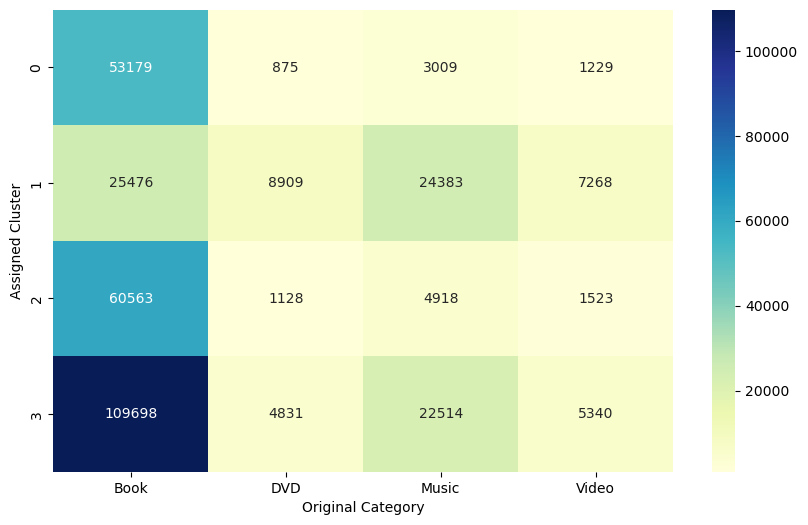

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

# Normalized Mutual Information (NMI)

## A. Structural Features

In [ ]:
import os
import pandas as pd
from datetime import datetime

RESULTS_FILE = "../data/results/clustering_results.csv"

def log_clustering_results(method_name, nmi):
    """
    Save clustering evaluation results to a CSV file.
    Args:
        method_name (str): Name of the clustering method.
        nmi (float): Normalized Mutual Information score.
    """
    new_entry = pd.DataFrame([{
        'method': method_name, 
        'NMI': round(nmi, 4)
    }])

    if not os.path.exists(RESULTS_FILE):
        os.makedirs(os.path.dirname(RESULTS_FILE), exist_ok=True)
        new_entry.to_csv(RESULTS_FILE, index=False)
    else:
        new_entry.to_csv(RESULTS_FILE, mode='a', header=False, index=False)

    print(f"Clustering results for {method_name} saved corrctly.")

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

df_eval_struct = df_final.dropna(subset=['group', 'cluster_kmeans'])

nmi_struct = normalized_mutual_info_score(df_eval_struct['group'], df_eval_struct['cluster_kmeans'])

print(f"Normalized Mutual Information (NMI): {nmi_struct:.4f}")

log_clustering_results("Structural + Salesrank", nmi_struct)

Normalized Mutual Information (NMI): 0.0255
Clustering results for Structural + Salesrank saved corrctly.


## B. Learned Features

In [ ]:
df_eval_emb = df_final.dropna(subset=['group', 'cluster_kmeans_emb'])

nmi_emb = normalized_mutual_info_score(df_eval_emb['group'], df_eval_emb['cluster_kmeans_emb'])

print(f"Normalized Mutual Information (NMI): {nmi_emb:.4f}")

log_clustering_results("Learned (Embeddings)", nmi_emb)

Normalized Mutual Information (NMI): 0.0829
Clustering results for Learned (Embeddings) saved corrctly.


## C. Hybrid Features

In [ ]:

df_eval_hybrid = df_final.dropna(subset=['group', 'cluster_hybrid'])

nmi_hybrid = normalized_mutual_info_score(df_eval_hybrid['group'], df_eval_hybrid['cluster_hybrid'])

print(f"Normalized Mutual Information (NMI): {nmi_hybrid:.4f}")

log_clustering_results("Hybrid (Balanced)", nmi_hybrid)

Normalized Mutual Information (NMI): 0.0244
Clustering results for Hybrid (Balanced) saved corrctly.


SUMMARY:


,NMI
method,
Learned (Embeddings),0.0829
Structural + Salesrank,0.0255
Hybrid (Balanced),0.0244


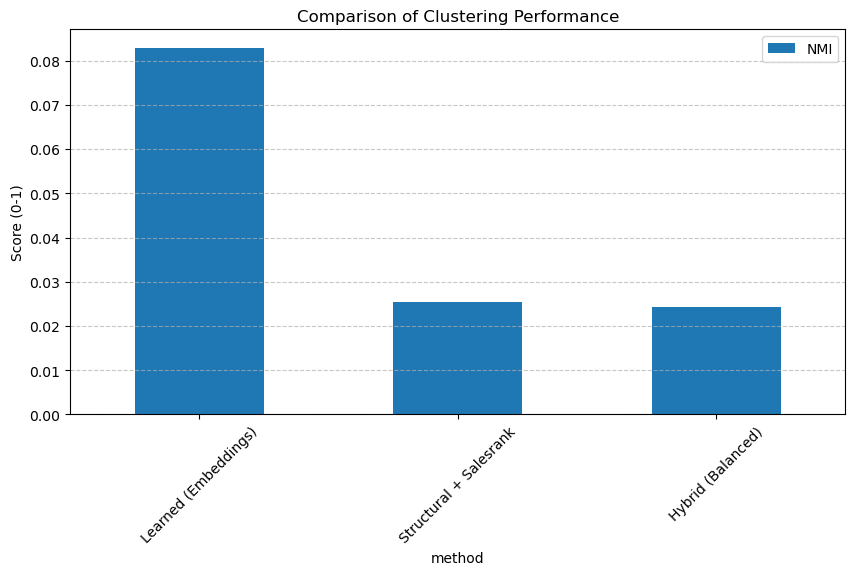

In [ ]:
# Upload results
df_results = pd.read_csv(RESULTS_FILE)

# Group them by
summary = df_results.groupby('method')[['NMI']].last().sort_values('NMI', ascending=False)

# Print table for comparisons
print("SUMMARY:")
display(summary)

# Plot
summary.plot(kind='bar', figsize=(10, 5))
plt.title("Comparison of Clustering Performance")
plt.ylabel("Score (0-1)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Original Categories plotting

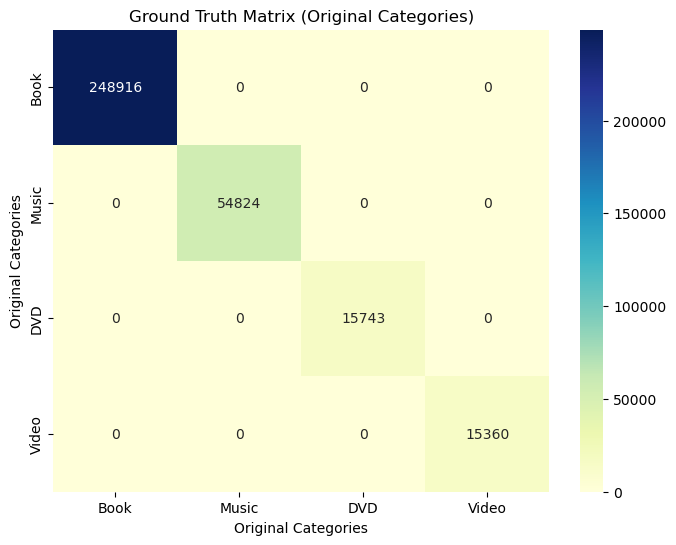

In [ ]:
# Original clustering
# Print the original clustering figure

# Extract ground truth groups from the graph
groups_dict = nx.get_node_attributes(G, 'group')
groups_series = pd.Series(groups_dict)

# Count occurrences of each category
counts = groups_series.value_counts()
categories = counts.index.tolist()

# Make an empty confusion matrix
gt_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Fill the diagonal with the real counts
for cat in categories:
    gt_matrix.loc[cat, cat] = counts[cat]

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(gt_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Ground Truth Matrix (Original Categories)')
plt.xlabel('Original Categories')
plt.ylabel('Original Categories')
plt.show()